In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install -q kaggle


In [7]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 93% 610M/658M [00:05<00:00, 111MB/s] 
100% 658M/658M [00:06<00:00, 113MB/s]


In [8]:
!unzip -q plantdisease.zip -d plant_disease_data

In [9]:
import os
from PIL import Image

print(os.listdir('plant_disease_data'))

['plantvillage', 'PlantVillage']


In [10]:
from pathlib import Path

root = Path('/content')
for item in root.iterdir():
    print(item)


/content/.config
/content/plantdisease.zip
/content/kaggle.json
/content/plant_disease_data
/content/sample_data


In [11]:
data_dir = Path('/content/plant_disease_data')
for item in (data_dir / "PlantVillage").iterdir():
    print(item)

/content/plant_disease_data/PlantVillage/Potato___healthy
/content/plant_disease_data/PlantVillage/Potato___Early_blight
/content/plant_disease_data/PlantVillage/Potato___Late_blight
/content/plant_disease_data/PlantVillage/Tomato_Septoria_leaf_spot
/content/plant_disease_data/PlantVillage/Tomato__Target_Spot
/content/plant_disease_data/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
/content/plant_disease_data/PlantVillage/Pepper__bell___healthy
/content/plant_disease_data/PlantVillage/Tomato_Bacterial_spot
/content/plant_disease_data/PlantVillage/Tomato__Tomato_mosaic_virus
/content/plant_disease_data/PlantVillage/Tomato_Leaf_Mold
/content/plant_disease_data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
/content/plant_disease_data/PlantVillage/Tomato_Late_blight
/content/plant_disease_data/PlantVillage/Tomato_healthy
/content/plant_disease_data/PlantVillage/Tomato_Early_blight
/content/plant_disease_data/PlantVillage/Pepper__bell___Bacterial_spot


Setup & Data Loading

In [12]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Setting  image parameters
IMG_SIZE = (224, 224)
BATCH = 32


# data_dir = Path('/content/plant_disease_data/PlantVillage')
data_dir = Path('/content/plant_disease_data/PlantVillage')

assert data_dir.exists(), f"Dataset directory {data_dir} not found."

In [78]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=str(data_dir),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode='int')

val_ds = tf.keras.utils.image_dataset_from_directory(
     directory=str(data_dir),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode='int'
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [80]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("The class_names are:",class_names)
print("The num_classes are:",num_classes)

The class_names are: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
The num_classes are: 15


In [35]:
from tensorflow.keras import layers

normalization_layer = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    layers.Rescaling(1./255)
])
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))

In [36]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
val_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Data Augmentation

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    horizontal_flip=True, brightness_range=[0.8,1.2])
aug_train_ds = aug.flow_from_directory(data_dir, target_size=IMG_SIZE,
                                       batch_size=BATCH, subset='training')


Found 20638 images belonging to 15 classes.


In [39]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

ResNet-18 Model

In [40]:
from tensorflow.keras import Model, Input

def resnet_block(x, filters, downsample=False):
    y = layers.Conv2D(filters, 3, padding='same', strides=(2 if downsample else 1))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, 3, padding='same')(y)
    y = layers.BatchNormalization()(y)
    if downsample:
        x = layers.Conv2D(filters, 1, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
    out = layers.Add()([x, y])
    out = layers.ReLU()(out)
    return out

inputs = Input(shape=(*IMG_SIZE, 3))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = resnet_block(x, 64, downsample=False)
x = resnet_block(x, 64, downsample=False)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128, downsample=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


Training with Class Weights

In [41]:
import numpy as np
from sklearn.utils import class_weight


y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)


if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.3407226958993097), 1: np.float64(0.9188091263216472), 2: np.float64(1.3656741108354011), 3: np.float64(1.418470790378007), 4: np.float64(8.949051490514906), 5: np.float64(0.6425763767269896), 6: np.float64(1.3759166666666667), 7: np.float64(0.7147619047619047), 8: np.float64(1.4794802867383512), 9: np.float64(0.7675964667596467), 10: np.float64(0.8117502458210423), 11: np.float64(0.9827976190476191), 12: np.float64(0.4354166666666667), 13: np.float64(3.681382385730212), 14: np.float64(0.8784783187017824)}


In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)



Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.5707 - loss: 1.3391 - val_accuracy: 0.2850 - val_loss: 5.1042
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 67s 78ms/step - accuracy: 0.7895 - loss: 0.6390 - val_accuracy: 0.3853 - val_loss: 2.9783
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.8374 - loss: 0.4772 - val_accuracy: 0.5256 - val_loss: 1.9129
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.8605 - loss: 0.4220 - val_accuracy: 0.5227 - val_loss: 2.7714
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.8855 - loss: 0.3330 - val_accuracy: 0.5362 - val_loss: 2.0677
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.8958 - loss: 0.3024 - val_accuracy: 0.2508 - val_loss: 8.7732
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.9063 - loss: 0.2755 - val_accuracy: 0.4962 - val_loss: 2.1621
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.9287 - loss: 0.2051 -

Evaluation & Metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

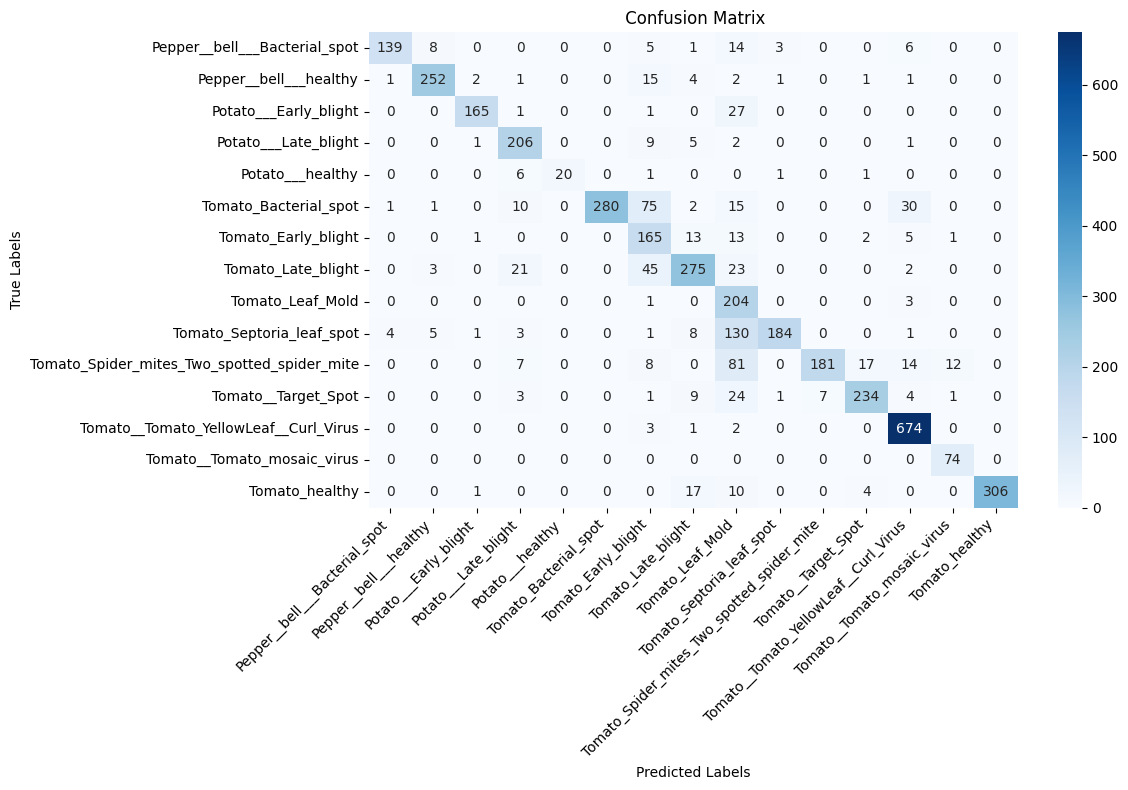

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n Classification Metrics:\n")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}\n")

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(" Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



The confusion matrix reveals that:

High Performing Classes:


Tomato__Tomato_YellowLeaf__Curl_Virus and Tomato_healthy have excellent classification accuracy, with most predictions landing in the correct class (674 and 306 correct predictions respectively).

 Pepper__bell___healthy and Potato___Early_blight are also reasonably well classified.

Moderate Confusion:

Classes like Tomato_Late_blight, Tomato_Leaf_Mold, and Tomato_Spider_mites_Two_spotted_spider_mite show moderate confusion with neighboring disease classes, indicating overlapping features.

Poorly Classified Classes:

 Tomato_Bacterial_spot, Tomato_Target_Spot, and Potato___healthy show significant confusion and misclassification, possibly due to similar visual features or underrepresentation in training data.

Diagonal Dominance:

The matrix shows good diagonal dominance overall — a sign the model is learning, but some misclassifications indicate room for improvement.

Model Size & Inference Speed

In [46]:
model.save('resnet18_model.h5')
import os
size_mb = os.path.getsize('resnet18_model.h5') / (1024**2)
print(f"Model size: {size_mb:.2f} MB")


Model size: 8.03 MB


In [47]:
import time
sample_batch = next(iter(val_ds.take(1)))[0]  # one batch of images
start = time.time()
preds = model.predict(sample_batch)
elapsed = time.time() - start
print(f"Inference time per image: {(elapsed/len(sample_batch))*1000:.2f} ms")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Inference time per image: 3.45 ms


Visualizations

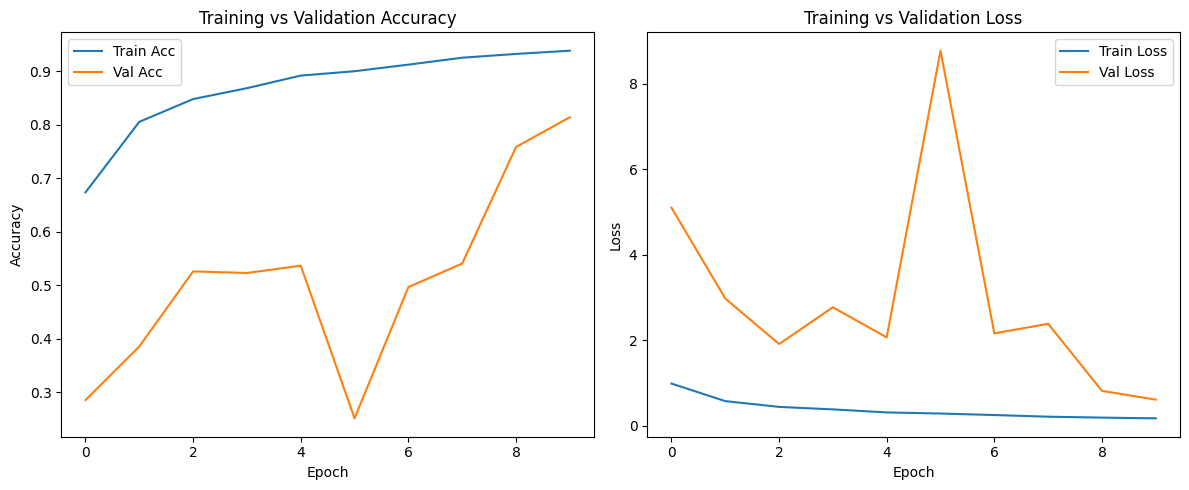

In [49]:
hist = history.history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()



Sample Predictions

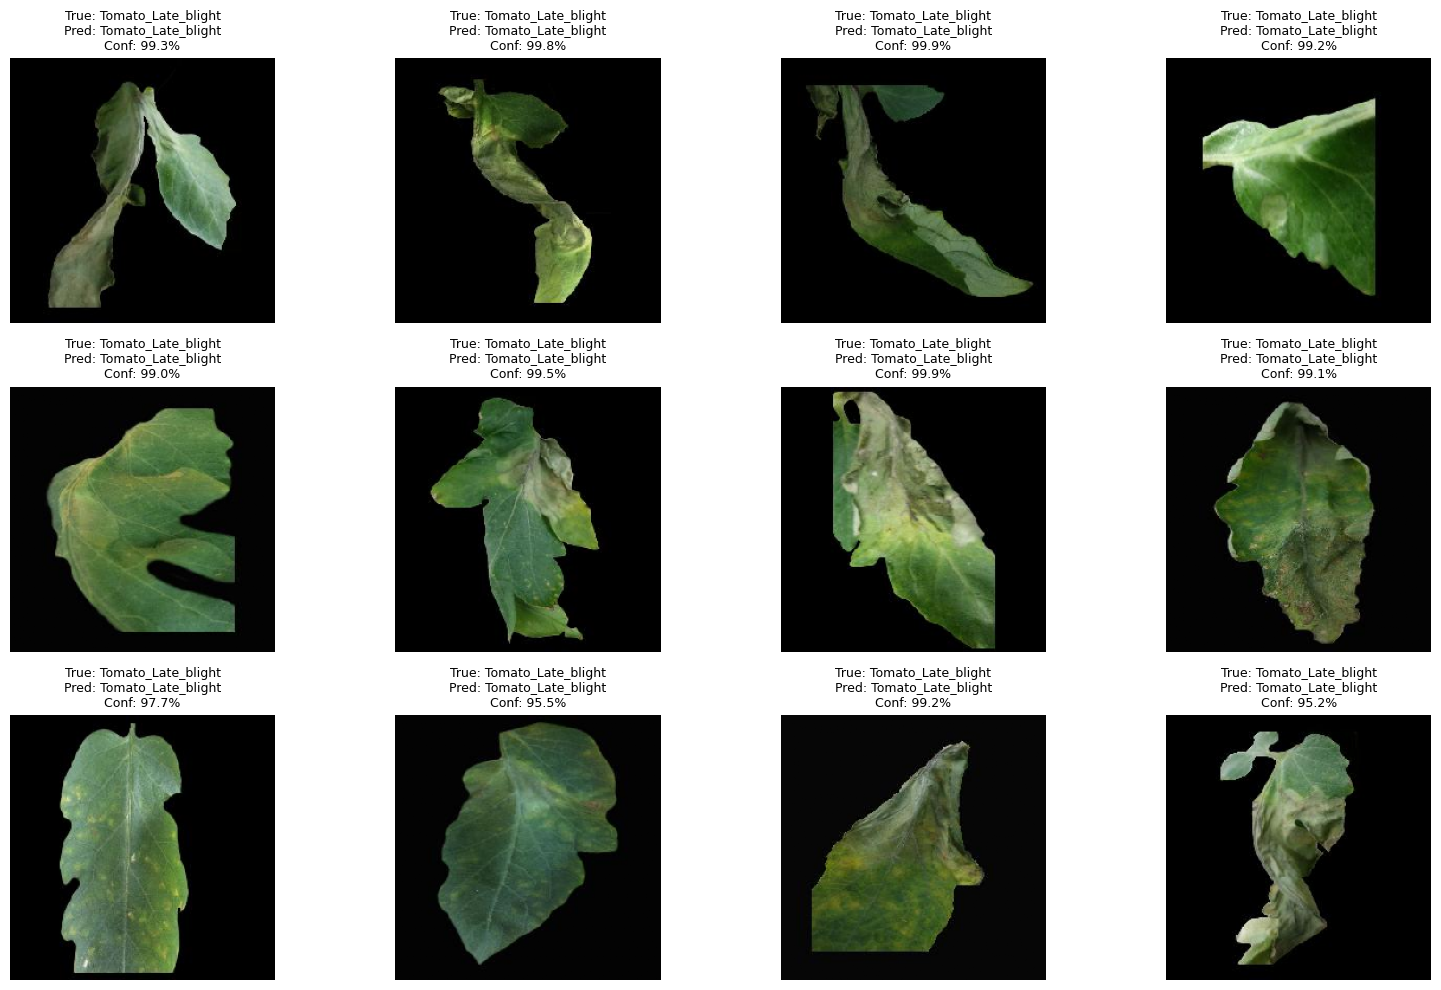

In [81]:
IMG_SIZE = (224, 224)
NUM_SAMPLES = 12
ROWS, COLS = 3, 4
data_dir = Path('/content/plant_disease_data/PlantVillage')


class_names = train_ds.class_names


all_images = list(data_dir.rglob("*.jpg"))
sample_paths = np.random.choice(all_images, size=NUM_SAMPLES, replace=False)

# Plot
plt.figure(figsize=(16, 10))

for i, img_path in enumerate(sample_paths):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)


    preds = model.predict(img_batch, verbose=0)
    pred_class = class_names[np.argmax(preds)]

    confidence = np.max(preds) * 100


    true_label = img_path.parts[-2]

    plt.subplot(ROWS, COLS, i + 1)
    plt.imshow(img_array)
    plt.title(f"True: {true_label}\nPred: {pred_class}\nConf: {confidence:.1f}%", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.savefig("sample_predictions_resnet.png", dpi=300)
plt.show()


Prediction Function


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sample 1:
  True class:       Tomato_Late_blight
  Predicted class:  Tomato_Late_blight
  Confidence:      49.32%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 2:
  True class:       Tomato_Leaf_Mold
  Predicted class:  Tomato_Leaf_Mold
  Confidence:      100.00%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sample 3:
  True class:       Tomato_healthy
  Predicted class:  Tomato_healthy
  Confidence:      99.94%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 4:
  True class:       Tomato_Septoria_leaf_spot
  Predicted class:  Tomato_Septoria_leaf_spot
  Confidence:      88.90%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sample 5:
  True class:       Pepper__bell___Bacterial_spot
  Predicted class:  Pepper__bell___Bacterial_spot
  Confidence:      99.57%



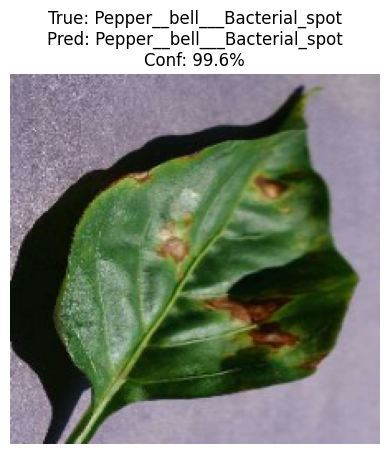

In [83]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def predict_plant_disease_resnet_from_array(img_array, model, class_names):
    img = tf.image.resize(img_array, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0  # ✅ Normalize manually (same as training)
    img_batch = tf.expand_dims(img, axis=0)

    preds = model.predict(img_batch)
    pred_idx = np.argmax(preds, axis=1)[0]
    return class_names[pred_idx], np.max(preds) * 100


for images, labels in val_ds.take(1):
    for i in range(5):  # Check 5 samples
        img = images[i]
        true_label_idx = labels[i].numpy()

        pred_class, confidence = predict_plant_disease_resnet_from_array(img, model, class_names)
        true_class = class_names[true_label_idx]

        print(f"Sample {i+1}:")
        print("  True class:      ", true_class)
        print("  Predicted class: ", pred_class)
        print("  Confidence:      {:.2f}%\n".format(confidence))


    import matplotlib.pyplot as plt
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%")
    plt.axis('off')
    plt.show()



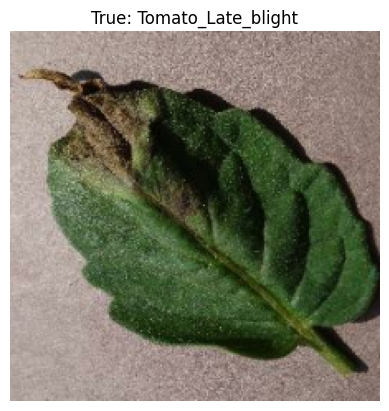

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 True Class:      Tomato_Late_blight
 Predicted Class: Tomato_Late_blight
 Confidence:      49.32%


In [91]:
img = images[0]
true_label_idx = labels[0].numpy()
true_class = class_names[true_label_idx]


img_norm = tf.cast(img, tf.float32) / 255.0


plt.imshow(img_norm.numpy())
plt.title(f"True: {true_class}")
plt.axis('off')
plt.show()


pred_class, confidence = predict_plant_disease_resnet_from_array(img, model, class_names)


print(f" True Class:      {true_class}")
print(f" Predicted Class: {pred_class}")
print(f" Confidence:      {confidence:.2f}%")


Saving and Loading the Model (Optional)

In [92]:
model.save('plant_disease_ResNet18.h5')